# Exploring the use of dust-MS correlation to create age models for Scotia Sea sediment cores 
### Motivation and Research Questions
<br>

### Set up document

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import xarray as xr
import pandas as pd
import math
from cartopy import crs as ccrs, feature as cfeature
import cartopy.io.shapereader as shpreader
from glob import glob
plt.rcParams['figure.figsize']=(12,6)

### Figure 1. 
Map showing locations of IODP Site U1537, ODP Site 1090, and Epica Dome C Ice Core (used for Weber et al. 2022 study).

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


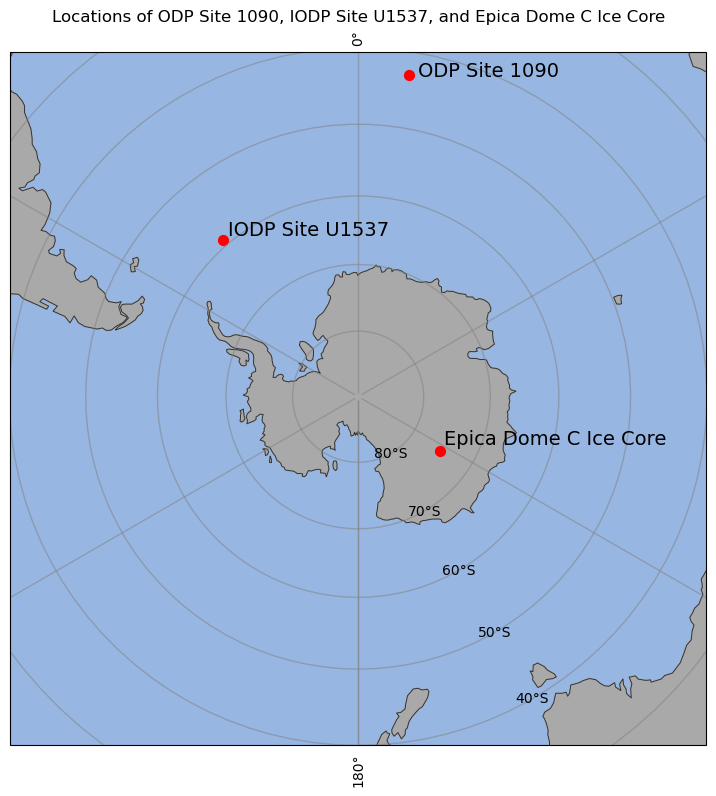

In [4]:
projStr = ccrs.SouthPolarStereo()
res = '10 m'

fig = plt.figure(figsize=(13,9))
ax = plt.subplot(1, 1, 1, projection=projStr)
ax.set_extent([-180, 180, -40, -40], ccrs.PlateCarree())
ax.set_facecolor(cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND, color = 'darkgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.7, color='0.2')


gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5
)

#add points for core coords
    # U1537: -59.110833°, -40.906167° in 3713 m of water.
    # 1090: Latitude: -42.908333, Longitude: 8.9, in 3702 m of water
    # EDC: -75.1, 123.35, altitude 3,233 m above sea level
coordslat = ([-59.110833, -42.90833, -75.1])
coordslon = ([-40.906167, 8.9, 123.35])
ax.scatter(coordslon, coordslat, transform = ccrs.PlateCarree(), s=50, c='red')
ax.text(-38.906167, -59.110833, 'IODP Site U1537',transform = ccrs.PlateCarree(), fontsize=14)
ax.text(10.5, -42.90833, 'ODP Site 1090', transform = ccrs.PlateCarree(), fontsize=14)
ax.text(119.35,  -75.1, 'Epica Dome C Ice Core', transform = ccrs.PlateCarree(), fontsize=14)
plt.title("Locations of ODP Site 1090, IODP Site U1537, and Epica Dome C Ice Core")
plt.show()



/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


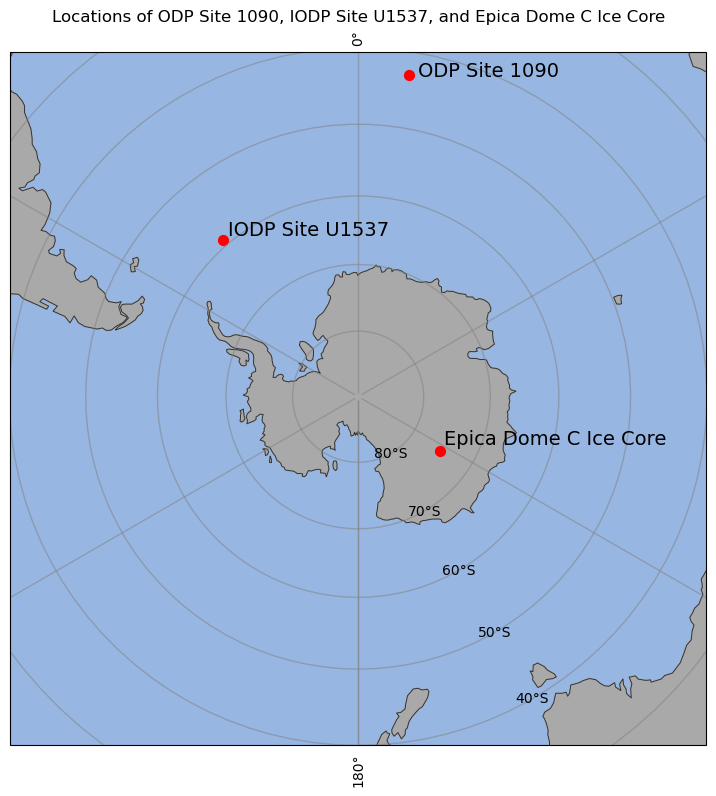

In [4]:
projStr = ccrs.SouthPolarStereo()
res = '10 m'

fig = plt.figure(figsize=(13,9))
ax = plt.subplot(1, 1, 1, projection=projStr)
ax.set_extent([-180, 180, -40, -40], ccrs.PlateCarree())
ax.set_facecolor(cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND, color = 'darkgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.7, color='0.2')


gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5
)

#add points for core coords
    # U1537: -59.110833°, -40.906167° in 3713 m of water.
    # 1090: Latitude: -42.908333, Longitude: 8.9, in 3702 m of water
    # EDC: -75.1, 123.35, altitude 3,233 m above sea level
coordslat = ([-59.110833, -42.90833, -75.1])
coordslon = ([-40.906167, 8.9, 123.35])
ax.scatter(coordslon, coordslat, transform = ccrs.PlateCarree(), s=50, c='red')
ax.text(-38.906167, -59.110833, 'IODP Site U1537',transform = ccrs.PlateCarree(), fontsize=14)
ax.text(10.5, -42.90833, 'ODP Site 1090', transform = ccrs.PlateCarree(), fontsize=14)
ax.text(119.35,  -75.1, 'Epica Dome C Ice Core', transform = ccrs.PlateCarree(), fontsize=14)
plt.title("Locations of ODP Site 1090, IODP Site U1537, and Epica Dome C Ice Core")
plt.show()



Load ODP 1090 Fe flux

In [5]:
fe = pd.read_csv('177-1090_Fe_dust_acc.tab',  sep = '\t', skiprows = 14) 
fe = fe.rename(columns = {"Age [ka BP]" : "fe_age" , "Acc rate Fe [mg/m**2/a]" : "iron", "DMAR [g/cm**2/ka]" : "dust"})
fe

,fe_age,iron,dust
0,0.33,73.07,2.09
1,0.65,79.09,1.78
2,0.98,79.68,2.15
3,1.31,86.27,2.08
4,1.63,90.28,1.74
...,...,...,...
6160,3990.10,47.05,1.39
6161,3990.53,48.46,1.43
6162,3994.78,69.18,2.02
6163,3997.42,68.07,1.99


Load U1537 MS. I have already identified tie points to ODP 1090 using the software Qanalyseries (see screenshot below); Qanalyseries automatically linearly interpolates between these tie points, generating the column named ms_age. 

![screenshot](qanalyseries.png)


In [6]:
ms = pd.read_csv('U1537_1090ages.txt', sep=" ")
ms.head()
ms = ms.rename(columns = {"Depth" : "ms_depth", "Age" : "ms_age", "Value" : "magsus"})
ms

,ms_depth,ms_age,magsus
0,0.025,1.31000,7.67
1,0.050,1.37548,9.00
2,0.075,1.44096,10.67
3,0.100,1.50643,11.00
4,0.125,1.57191,10.33
...,...,...,...
11029,288.651,2354.19000,14.00
11030,288.676,2354.40000,14.67
11031,288.701,2354.61000,15.00
11032,288.726,2354.82000,16.33


Load tie points generated from Qanalyseries. I will use this file to draw tie points on Figure 3 and 4.

In [8]:
tiepoints = pd.read_csv('U1537_1090timemodel.txt', sep=" ", header=None)
tiepoints = tiepoints.rename(columns = {0 : "tp_depth", 1 : "tp_age"})
tiepoints

,tp_depth,tp_age
0,0.025,1.31
1,8.944,24.67
2,16.211,66.13
3,19.846,87.18
4,24.050,110.17
...,...,...
67,244.136,1954.36
68,249.637,1993.53
69,263.794,2155.98
70,269.244,2190.81


### Figure 2. 
Stack plot. Top plot shows reference curve (ODP 1090 Fe Accumulation Rate) vs. age, bottom plot shows U1537 MS vs. depth.

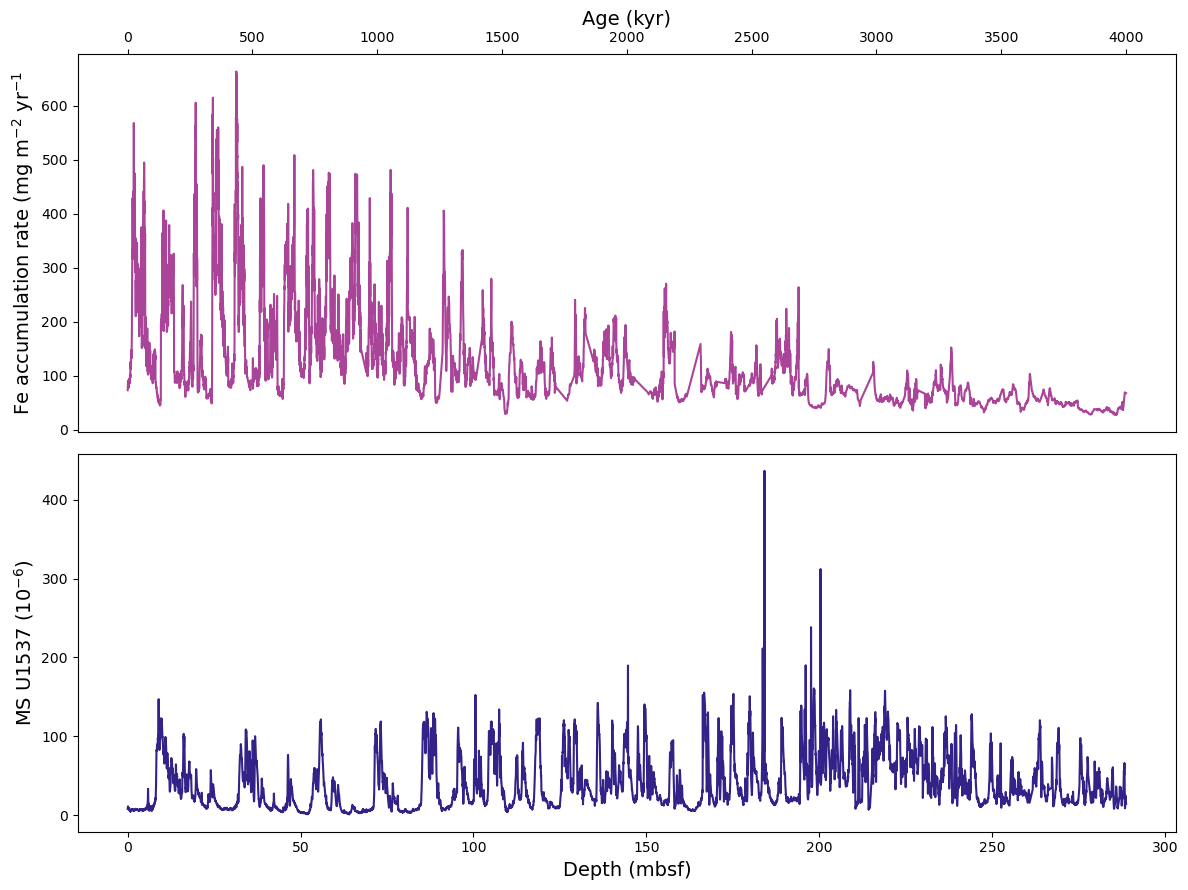

In [9]:
fig, axes = plt.subplots(figsize=(12,9), nrows=2)
ax1, ax2 = axes

ax1.plot(fe.fe_age, fe.iron, c='#AA4499')
ax1.set_xlabel('Age (kyr)', fontsize=14)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top') 
ax1.set_ylabel(r'Fe accumulation rate (mg m$^{-2}$ yr$^{-1}$', fontsize=14)
ax1.set_ylabel(r'Fe accumulation rate (mg m$^{-2}$ yr$^{-1}$', fontsize=14)

ax2.plot(ms.ms_depth, ms.magsus, c='#332288')
ax2.set_xlabel('Depth (mbsf)', fontsize=14)
ax2.set_ylabel(r'MS U1537 (10$^{-6}$)', fontsize=14)

fig.tight_layout()

### Figure 3. 
Same stack plot as Figure 2, now showing tie points.

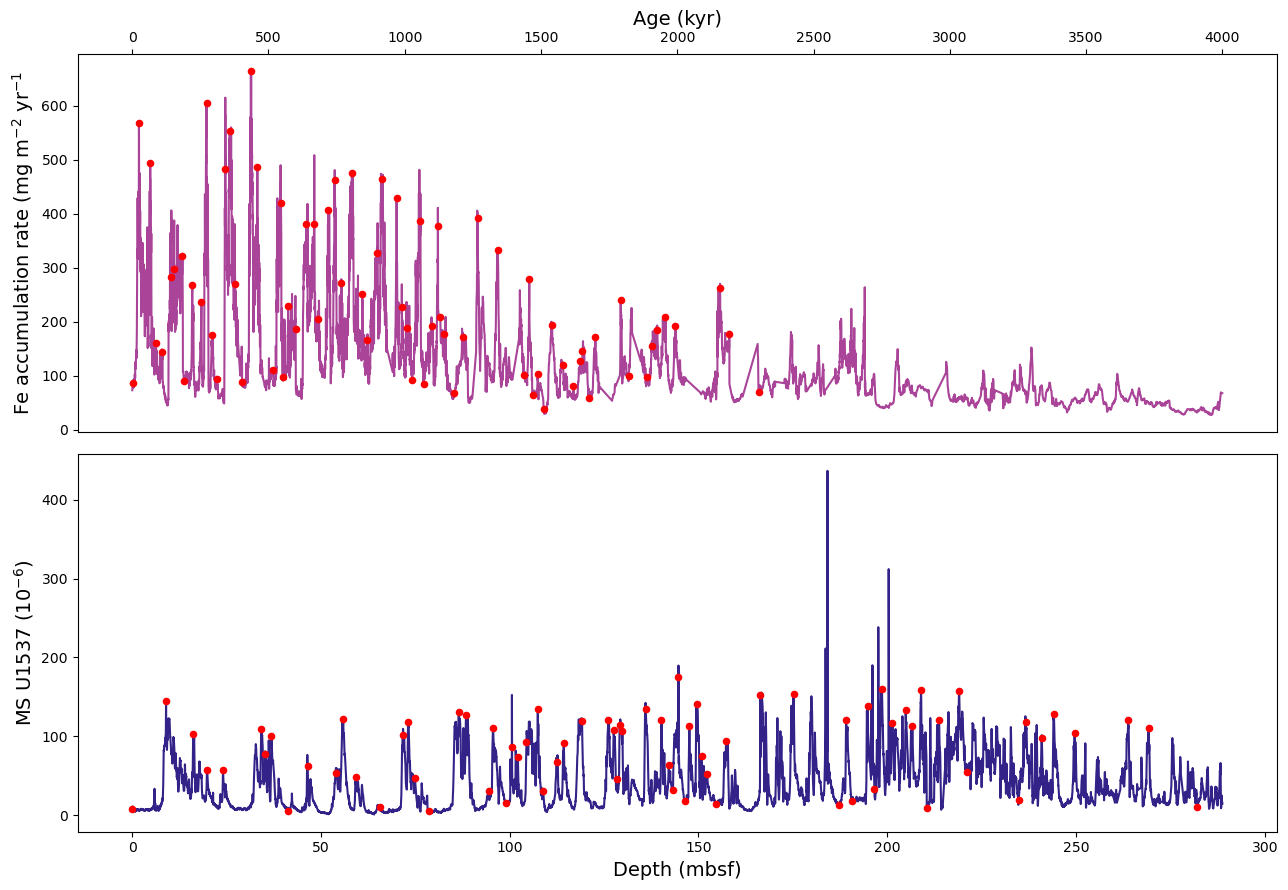

In [10]:
fig, axes = plt.subplots(figsize=(13,9), nrows=2)
ax1, ax2 = axes

x = fe.fe_age
y = fe.iron
ax1.plot(x, y, c='#AA4499')
highlights = [y[np.abs(x - xi).argmin()] for xi in tiepoints.tp_age]
ax1.scatter(tiepoints.tp_age, highlights, color='red', zorder=5, s=20)
ax1.set_ylabel(r'Fe accumulation rate (mg m$^{-2}$ yr$^{-1}$', fontsize=14)
ax1.set_xlabel('Age (kyr)', fontsize=14)
ax1.xaxis.set_label_position('top') 
ax1.xaxis.tick_top()


x2 = ms.ms_depth
y2 = ms.magsus
ax2.plot(x2, y2, c='#332288')
highlights2 = [y2[np.abs(x2 - x2i).argmin()] for x2i in tiepoints.tp_depth]
ax2.scatter(tiepoints.tp_depth, highlights2, color='red', zorder=5, s=20)
ax2.set_ylabel(r'MS U1537 (10$^{-6}$)', fontsize=14)
ax2.set_xlabel('Depth (mbsf)', fontsize=14)

fig.tight_layout()

### Figure 4. 
Final iteration of stackplot: both curves are now plotted against age. Dotted line at 800 ka (ice core end).

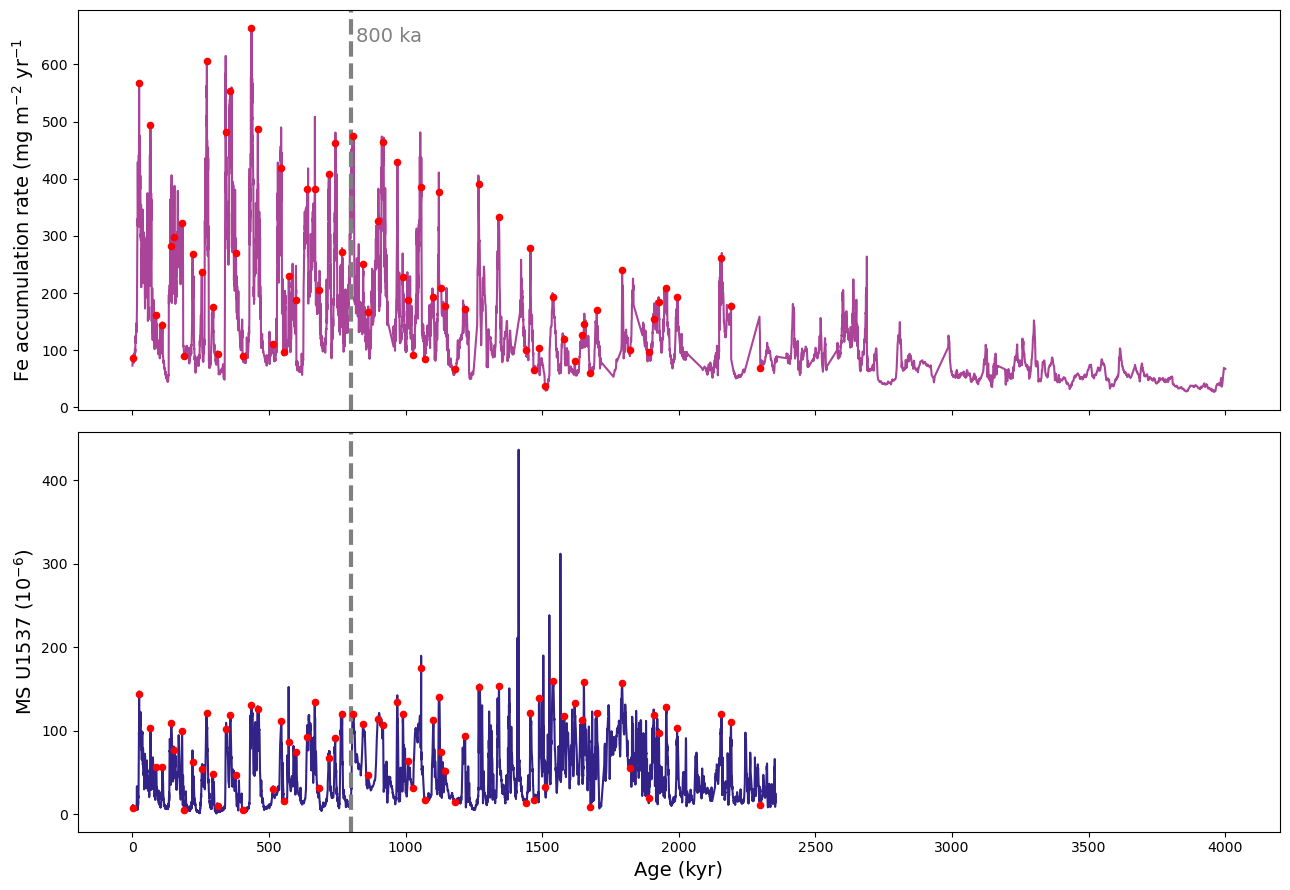

In [11]:
fig, axes = plt.subplots(figsize=(13,9), nrows=2, sharex=True)
ax1, ax2 = axes

ax1.plot(x, y, c='#AA4499')
highlights = [y[np.abs(x - xi).argmin()] for xi in tiepoints.tp_age]
ax1.scatter(tiepoints.tp_age, highlights, color='red', zorder=5, s=20)
ax1.set_ylabel(r'Fe accumulation rate (mg m$^{-2}$ yr$^{-1}$', fontsize=14)
ax1.axvline(x=800, ymin=0, ymax = y.max(), lw=3, ls='--', c='0.5')
ax1.text(820, 640, '800 ka', fontsize=14, c='0.5')

x3 = ms.ms_age
ax2.plot(x3, y2, c='#332288')
highlights2 = [y2[np.abs(x3 - x3i).argmin()] for x3i in tiepoints.tp_age]
ax2.scatter(tiepoints.tp_age, highlights2, color='red', zorder=5, s=20)
ax2.set_ylabel(r'MS U1537 (10$^{-6}$)', fontsize=14)
ax2.set_xlabel('Age (kyr)', fontsize=14)
ax2.axvline(x=800, ymin=0, ymax = y2.max(), lw=3, ls='--', c='0.5')

fig.tight_layout()

Concatenate the dataframes and sort according to age without repeating any ages. Drop Fe data that extends beyond U1537 timespan. This is necessary in order to determine correlations.

In [12]:
data = pd.concat([ms, fe], ignore_index=True)

In [13]:
n = ms.ms_age.size
N = data.ms_age.size
#print(n,N)
data.loc[n:N+1, "ms_age"] = data.loc[n:N+1, "fe_age"]
data.drop("fe_age", axis=1, inplace=True)
data = data.rename(columns = {"ms_age" : "age"})
data = data.sort_values(by='age', ignore_index=True)
# dropping repeat ages
indices_to_drop = []
for i in range(1, N):
    if data.age[i] == data.age[i-1]: 
        data.loc[i-1, 'iron'] = data.loc[i, 'iron']
        data.loc[i-1, 'dust'] = data.loc[i, 'dust']
        indices_to_drop.append(i)
data = data.drop(indices_to_drop).reset_index(drop=True)
data = data[0:15661] # drop rows past the end of the MS dataset
data

,ms_depth,age,magsus,iron,dust
0,NaN,0.33000,NaN,73.07,2.09
1,NaN,0.65000,NaN,79.09,1.78
2,NaN,0.98000,NaN,79.68,2.15
3,0.025,1.31000,7.67,86.27,2.08
4,0.050,1.37548,9.00,NaN,NaN
...,...,...,...,...,...
15656,288.676,2354.40000,14.67,NaN,NaN
15657,288.701,2354.61000,15.00,NaN,NaN
15658,288.726,2354.82000,16.33,NaN,NaN
15659,NaN,2355.02000,NaN,81.75,2.32


Find correlations for whole dataset as well as before and after 800 ka (end of ice core).

In [14]:
data.corr()

,ms_depth,age,magsus,iron,dust
ms_depth,1.000000,0.995835,0.219273,-0.533902,-0.525059
age,0.995835,1.000000,0.222121,-0.387391,-0.382023
magsus,0.219273,0.222121,1.000000,0.623408,0.655895
iron,-0.533902,-0.387391,0.623408,1.000000,0.976496
dust,-0.525059,-0.382023,0.655895,0.976496,1.000000


In [15]:
data[data.age <= 800].corr()

,ms_depth,age,magsus,iron,dust
ms_depth,1.000000,0.986840,0.086380,0.095110,0.149774
age,0.986840,1.000000,0.096398,-0.034080,-0.002492
magsus,0.086380,0.096398,1.000000,0.836925,0.879696
iron,0.095110,-0.034080,0.836925,1.000000,0.973581
dust,0.149774,-0.002492,0.879696,0.973581,1.000000


In [16]:
data[data.age > 800].corr()

,ms_depth,age,magsus,iron,dust
ms_depth,1.000000,0.998586,-0.087663,-0.314576,-0.334866
age,0.998586,1.000000,-0.078688,-0.467640,-0.490262
magsus,-0.087663,-0.078688,1.000000,0.673258,0.658409
iron,-0.314576,-0.467640,0.673258,1.000000,0.980965
dust,-0.334866,-0.490262,0.658409,0.980965,1.000000


In [17]:
# setting index to age, which will enable a rolling correlation
data = data.set_index('age', drop=False)
data

,ms_depth,age,magsus,iron,dust
age,,,,,
0.33000,NaN,0.33000,NaN,73.07,2.09
0.65000,NaN,0.65000,NaN,79.09,1.78
0.98000,NaN,0.98000,NaN,79.68,2.15
1.31000,0.025,1.31000,7.67,86.27,2.08
1.37548,0.050,1.37548,9.00,NaN,NaN
...,...,...,...,...,...
2354.40000,288.676,2354.40000,14.67,NaN,NaN
2354.61000,288.701,2354.61000,15.00,NaN,NaN
2354.82000,288.726,2354.82000,16.33,NaN,NaN


Create columns that linearly interpolate in order to avoid NaN values. This is necessary for the running correlation as well as for plotting.

In [18]:
msint = data.magsus.interpolate(method = 'linear')
msint = msint.rename("msint")
feint = data.iron.interpolate(method = 'linear')
feint = feint.rename("feint")
datint = pd.concat([data, msint, feint], axis=1)
datint

,ms_depth,age,magsus,iron,dust,msint,feint
age,,,,,,,
0.33000,NaN,0.33000,NaN,73.07,2.09,NaN,73.0700
0.65000,NaN,0.65000,NaN,79.09,1.78,NaN,79.0900
0.98000,NaN,0.98000,NaN,79.68,2.15,NaN,79.6800
1.31000,0.025,1.31000,7.67,86.27,2.08,7.67,86.2700
1.37548,0.050,1.37548,9.00,NaN,NaN,9.00,87.0720
...,...,...,...,...,...,...,...
2354.40000,288.676,2354.40000,14.67,NaN,NaN,14.67,85.4625
2354.61000,288.701,2354.61000,15.00,NaN,NaN,15.00,84.2250
2354.82000,288.726,2354.82000,16.33,NaN,NaN,16.33,82.9875


### Figure 5.
Stack plot. Top plot shows a visual comparison of the two curves, and bottom plot shows a rolling correlation between the two.

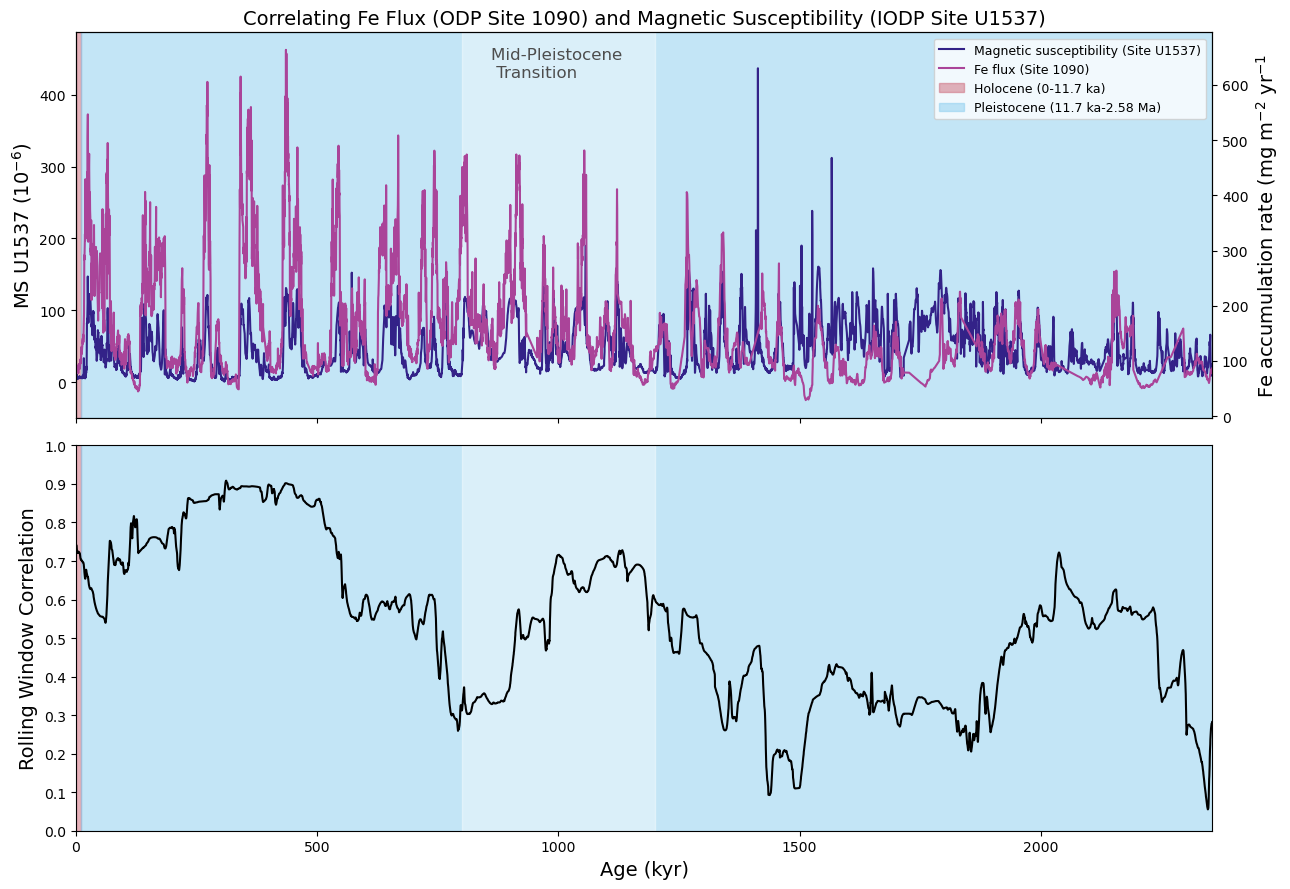

In [27]:

runningcorr = datint.msint.rolling(1000, on=datint.index, center=True, min_periods=1).corr(datint.feint)
# rolling window of 1000 allows us to see detail without curve being too noisy
fig, axes = plt.subplots(figsize=(13,9), nrows=2, sharex=True)
ax1, ax2 = axes

d = [11.7, 800, 1200, 2580, 3176.42]
ax2.set_xlim(0,datint.age.max())
ax2.set_ylim(0,1)
ax2.set_xlabel('Age (kyr)', fontsize=14)
ax2.set_ylabel('Rolling Window Correlation', fontsize=14)
ax2.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

#setting different background colors according to epoch
# using Paul Tol color schemes 
ax2.axvspan(0, 11.7, ymin=0, ymax=1, color='#CC6677', alpha=0.5, label= 'Holocene (0-11.7 ka)')
ax2.axvspan(11.7, 2580, ymin=0, ymax=1, color='#88CCEE', alpha=0.5, label= 'Pleistocene (11.7 ka-2.58 Ma)')
ax2.axvspan(d[1], d[2], color='1', alpha=0.4)

ax2.plot(runningcorr, c='black', )

#plotting using interpolation so that the line does not break at NaN values
# NaN values are at depths where there is data for one variable but not the other
msmin = datint.msint.min()-50
msmax = datint.msint.max()+50
ax1.plot(data.age, data.magsus.interpolate(method='linear'), c='#332288', label='Magnetic susceptibility (Site U1537)') 
ax1.set_ylabel(r'MS U1537 (10$^{-6}$)', fontsize=14)
ax1.set_ylim(msmin, msmax)
ax1.set_title("Correlating Fe Flux (ODP Site 1090) and Magnetic Susceptibility (IODP Site U1537)", fontsize=14)

ax1.axvspan(0, 11.7, ymin=0, ymax=1, color='#CC6677', alpha=0.5)
ax1.axvspan(11.7, 2580, ymin=0, ymax=1, color='#88CCEE', alpha=0.5)
ax1.axvspan(d[1], d[2], color='1', alpha=0.4)
ax1.annotate('Mid-Pleistocene \n Transition', xy = (0,0), xytext= (860, 425), color = '0.3', fontsize=12)

ax3 = ax1.twinx()
ax3.plot(data.age, data.iron.interpolate(method='linear'), c='#AA4499', label= 'Fe flux (Site 1090)')
ax3.set_ylabel(r'Fe accumulation rate (mg m$^{-2}$ yr$^{-1}$', fontsize=14)

# setting up legend so that both curves are in one panel
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
lines3, labels3 = ax2.get_legend_handles_labels()
ax3.legend(lines + lines2 +lines3, labels + labels2 + labels3, loc=0, fontsize=9)

fig.tight_layout()

## Conclusions
In this project, I used the Fe accumulation rate record from ODP Site 1090, interpreted to represent dust accumulation, as an age reference for IODP Site U1537, using Site U1537 magnetic susceptibility. After correlating the IODP Site U1537 record to the ODP Site 1090 record using the Qanalyseries software, I evaluated the correlations between U1537 MS and 1090 Fe/dust over the whole time interval, before and after 800 ka, and through the whole time interval (0-2.355 Ma). Results show that, over the ice core interval, the correlation of U1537 MS to ODP 1090 Fe accumulation rate is very similar to its correlation to EDC nssCa2+ (0.84 for Fe acc. rate and 0.87 for dust compared to 0.85 for ice core nssCa2+), validating its use as a reference for age model creation. Furthermore, correlations remain moderately high (0.67 for Fe accumulation rate and 0.66 for dust) after 800 ka, meaning that ODP 1090 is a good candidate for a reference to use for cores extending past the ice core record in time. The sharp drop in the correlation after 800 ka suggests a change to climatic processes of the Southern Ocean related to the Mid-Pleistocene Transition (MPT, 800 - 1200 ka), when glacial-interglacial cyclicity transitioned from 41-kyr to 100-kyr periods. This drop indicates that MS of Scotia Sea sediments was less strongly tied to atmospheric dust transition during and prior to the MPT. These results highlight the need for further study into the factors controlling the transport and deposition of terrigenous sediments in the Scotia Sea. 